In [1]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
import tensorflow as tf
import cv2
import imgaug.augmenters as iaa

# path to the model weights files.
weights_path = '../vgg16_weights.h5'
top_model_weights_path = 'weights/fc_model.h5'
# dimensions of our images.
img_width, img_height = 216, 384

temp_aug = iaa.ChangeColorTemperature((4000, 9000))
def augment_color_temperature(image):
    return temp_aug.augment_image(image.astype("uint8"))

In [2]:
def to_grayscale_then_rgb(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray_rgb = cv2.cvtColor(gray,cv2.COLOR_GRAY2RGB)
    return gray_rgb

In [3]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 5,
    #brightness_range = (0.05, 0.2),
    validation_split=0.2,
    #horizontal_flip = True,

    preprocessing_function=augment_color_temperature,
)

valgen = tf.keras.preprocessing.image.ImageDataGenerator(    
    #width_shift_range=0.2,
    #height_shift_range=0.2,
    #zoom_range=0.15,
    #shear_range=0.15,
    #rotation_range = 40,
    #brightness_range = (0.05, 0.2),
    validation_split=0.2,
    #horizontal_flip = True,

    #preprocessing_function=to_grayscale_then_rgb,
)


In [4]:
class_names = ['wada banderoli', 'wada nakretki', 'prawidlowa', 'brak nakretki']

In [5]:
my_seed = 11123

TRAIN_DIR = "../../dataset/butelka_wyciete_przez_niego"

#train_generator = datagen.flow_from_directory('processed_dataset/nowy', batch_size=32, class_mode='categorical', seed = 123, subset='training', classes=class_names, shuffle=True)
train_generator = datagen.flow_from_directory(TRAIN_DIR, (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='training', classes=class_names, shuffle=True)
val_generator = valgen.flow_from_directory(TRAIN_DIR, (img_height, img_width), batch_size=32, class_mode='categorical', seed = my_seed, subset='validation', classes=class_names, shuffle=True)

Found 9600 images belonging to 4 classes.
Found 2400 images belonging to 4 classes.


In [6]:
from collections import Counter

print("Training")
print(train_generator.class_indices)
print(Counter(train_generator.classes))
print("Validation")
print(val_generator.class_indices)
print(Counter(val_generator.classes))

num_classes = len(class_names)

Training
{'wada banderoli': 0, 'wada nakretki': 1, 'prawidlowa': 2, 'brak nakretki': 3}
Counter({0: 2400, 1: 2400, 2: 2400, 3: 2400})
Validation
{'wada banderoli': 0, 'wada nakretki': 1, 'prawidlowa': 2, 'brak nakretki': 3}
Counter({0: 600, 1: 600, 2: 600, 3: 600})


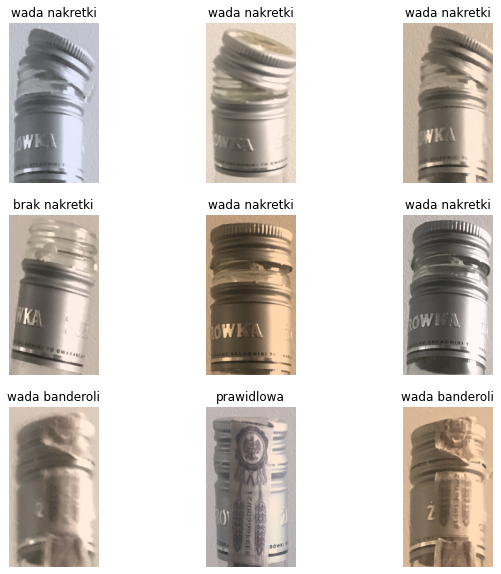

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 10))

for gen in range(3):
    x,y = train_generator.next()

    for i in range(3):
        ax = plt.subplot(3, 3, gen * 3 + i + 1)
        plt.imshow(x[i].astype("uint8"))
        plt.title(class_names[np.argmax(y[i])])
        plt.axis("off")

plt.show()

In [29]:
model = applications.vgg16.VGG16(weights='imagenet', include_top=False)
print('Model loaded.')

Model loaded.


In [30]:
from keras.layers import Input
from keras.models import Model
# build a classifier model to put on top of the convolutional model

input_tensor = Input(shape=(img_height, img_width,3))
#input_tensor = Input(shape=(150,150,3))
base_model = applications.vgg16.VGG16(weights='imagenet',include_top= False,input_tensor=input_tensor)

top_model = Sequential()
top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(num_classes, activation='softmax'))

# note that it is necessary to start with a fully-trained
# classifier, including the top classifier,
# in order to successfully do fine-tuning
#top_model.load_weights(top_model_weights_path)

# add the model on top of the convolutional base
model = Model(base_model.input, top_model(base_model.output))


In [31]:
base_model.input

<KerasTensor: shape=(None, 384, 216, 3) dtype=float32 (created by layer 'input_5')>

In [32]:
base_model.output

<KerasTensor: shape=(None, 12, 6, 512) dtype=float32 (created by layer 'block5_pool')>

In [33]:
new_model = Sequential()
for l in base_model.layers:
    new_model.add(l)


for l in top_model.layers:
    new_model.add(l)
# CONCATENATE THE TWO MODELS
print(new_model.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 384, 216, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 384, 216, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 192, 108, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 192, 108, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 192, 108, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 96, 54, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 96, 54, 256)      

In [34]:
len(base_model.layers)

19

In [35]:
for layer in new_model.layers[:len(base_model.layers) - 1]:
    layer.trainable = False

In [36]:
new_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics =['accuracy'])

In [37]:
epochs = 5

my_callbacks = [
    #tf.keras.callbacks.ModelCheckpoint(filepath='vgg_nowy.{epoch:02d}-{val_loss:.2f}.h5'),
]

history=new_model.fit(train_generator, epochs=epochs, callbacks=my_callbacks, validation_data=val_generator)


Epoch 1/5
300/300 [==============================] - 135s 448ms/step - loss: 2.1203 - accuracy: 0.9708 - val_loss: 1.1272 - val_accuracy: 0.9725
Epoch 2/5
300/300 [==============================] - 134s 448ms/step - loss: 0.4984 - accuracy: 0.9873 - val_loss: 1.4852 - val_accuracy: 0.9821
Epoch 3/5
300/300 [==============================] - 134s 447ms/step - loss: 0.6506 - accuracy: 0.9903 - val_loss: 2.0664 - val_accuracy: 0.9842
Epoch 4/5
300/300 [==============================] - 149s 495ms/step - loss: 0.1820 - accuracy: 0.9959 - val_loss: 0.9697 - val_accuracy: 0.9879
Epoch 5/5
300/300 [==============================] - 134s 447ms/step - loss: 0.3109 - accuracy: 0.9955 - val_loss: 1.1030 - val_accuracy: 0.9883


In [38]:
model.save('zlozonadosprawkanakretkizaug12.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


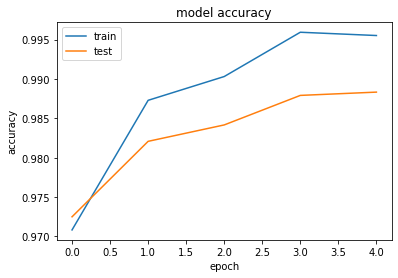

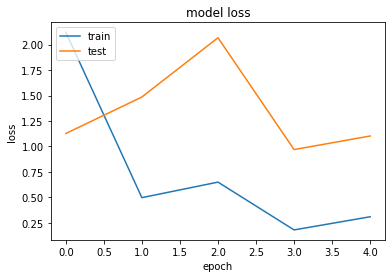

In [39]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()